In [59]:
# ----------------------------------------------------------------------------
#
# TITLE - sample_gaia_data.ipynb
# AUTHOR - James Lane
# PROJECT - OHStars
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Generate samples from 6D phase space taking into account errors and covariances
'''

__author__ = "James Lane"

'\nGenerate samples from 6D phase space taking into account errors and covariances\n'

In [33]:
### Imports

## Basic
import numpy as np
import sys, os, pdb, warnings

## Plotting
from matplotlib import pyplot as plt

## Scipy
from scipy import stats

## Astropy
# from astropy.io import fits
# from astropy.coordinates import SkyCoord
from astropy import table
from astropy import units as apu
from astropy.utils.exceptions import AstropyWarning
# from astropy import wcs

## galpy
# from galpy import orbit
# from galpy import potential
# from galpy.util import bovy_coords as gpcoords
# from galpy.util import bovy_conversion as gpconv
# from galpy.util import bovy_plot as gpplot

# Project-specific imports
sys.path.append('../../src/')
import ohstars.plot

In [34]:
### Change Jupyter settings

from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Markdown, display

# Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

# Print using markdown
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

# Meta
## Future Work

## Information
- Gaia co-variance information: https://www.aanda.org/articles/aa/pdf/2012/07/aa18807-12.pdf

# Read data

In [46]:
# Filename
filename = '../../data/gaia/allstars.vot'

# Read the file
with warnings.catch_warnings():
    warnings.simplefilter('ignore', AstropyWarning)
    tab = table.Table.read(filename)
    
n_stars = len(tab) # 6
star_names = tab['col1'].data.astype(str)

# Print a list of the column names
# tab.colnames

# Generate Sample
Loop over all stars, assemble the covariance array, and generate a statistical sample

In [47]:
## The radial velocity is from external source and is uncorrelated with gaia data
vrad = np.array([])
vrad_error = np.array([])

/Users/JamesLane/Software/Python/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


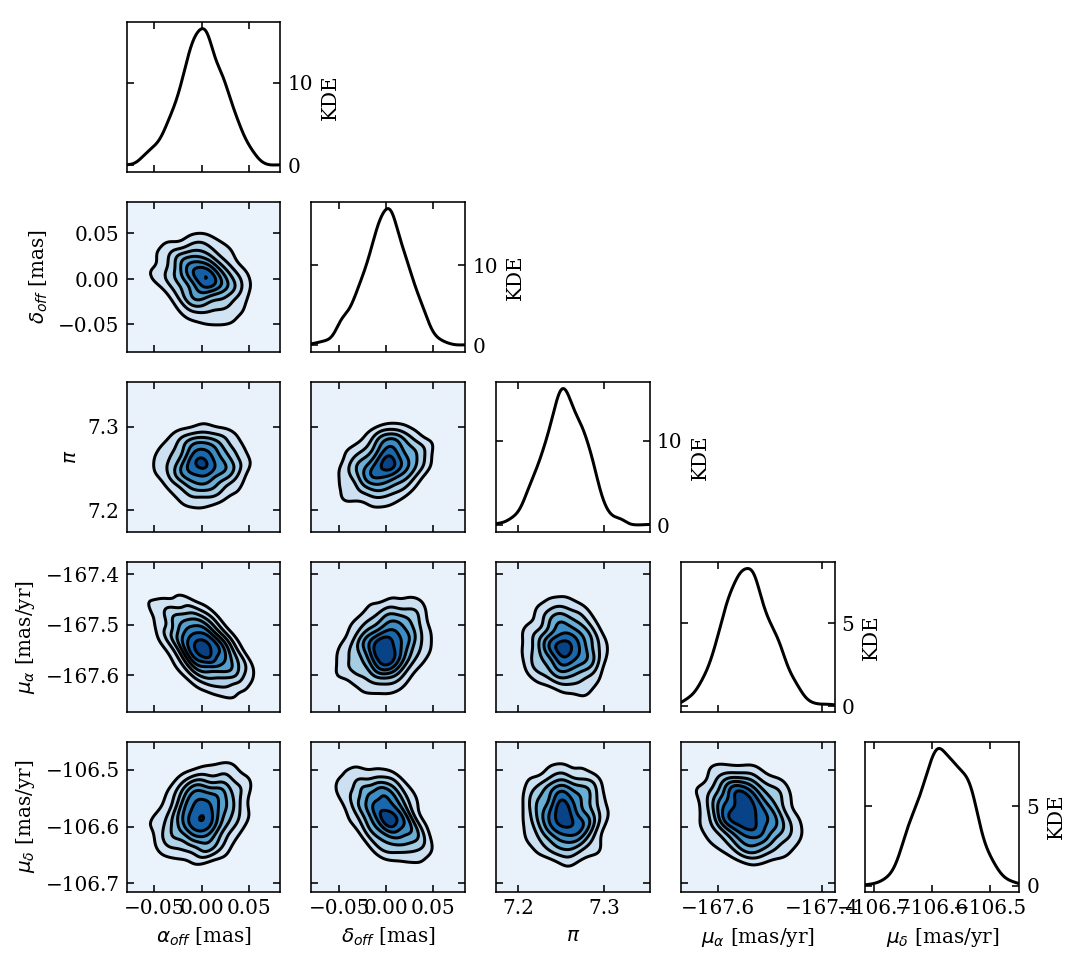

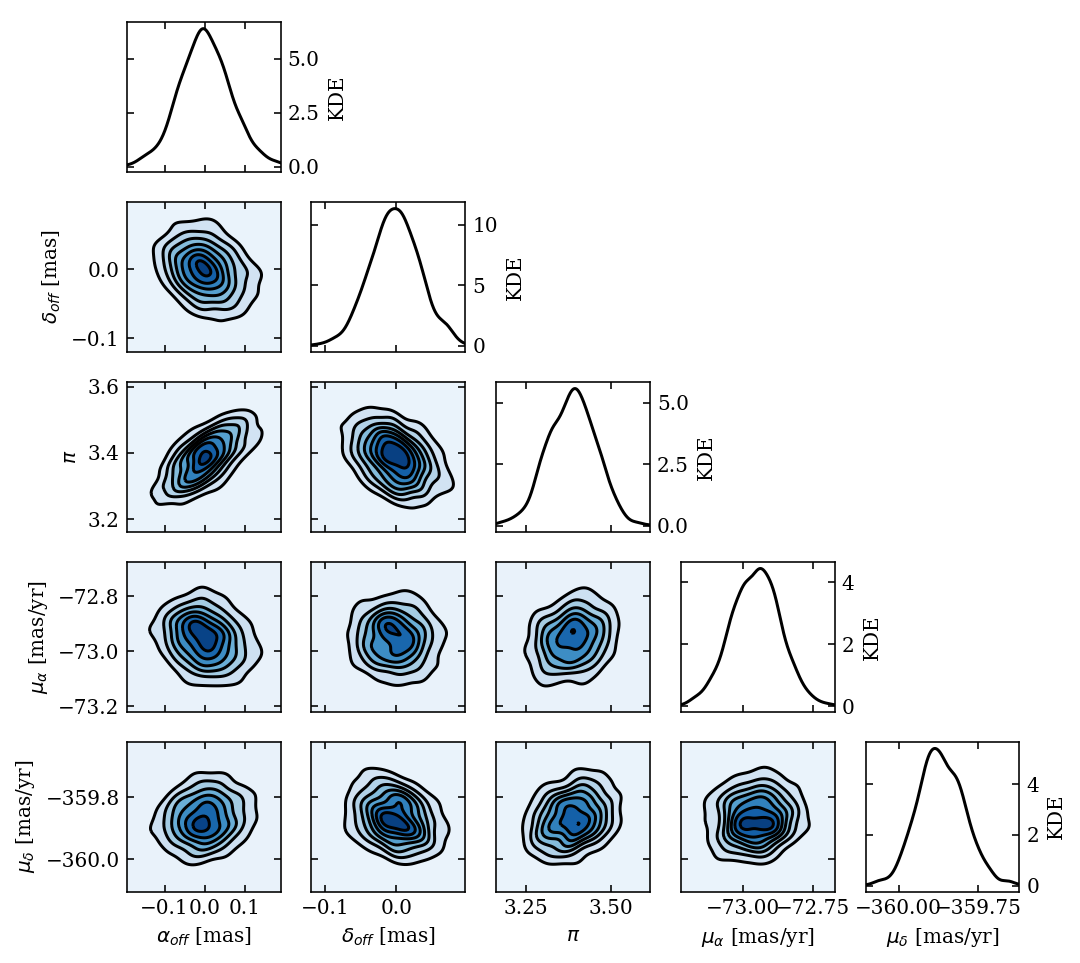

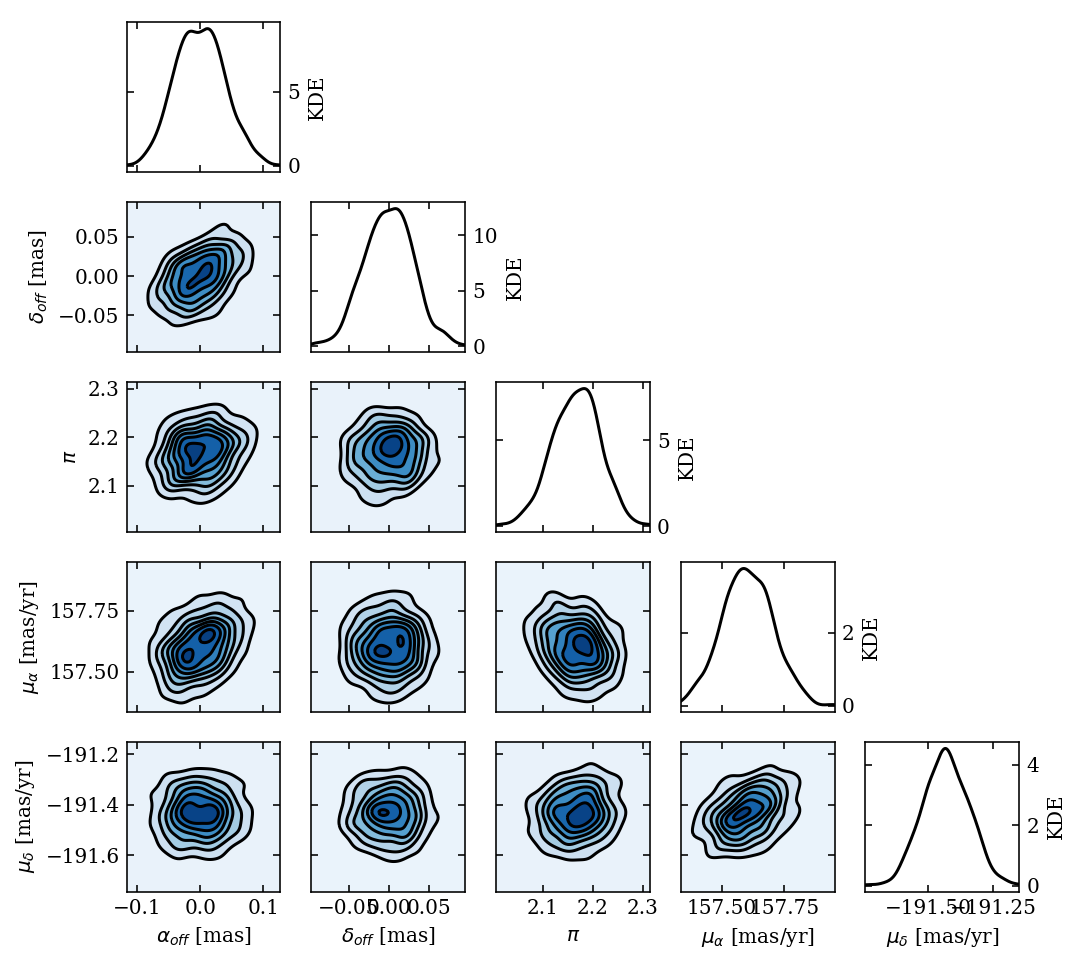

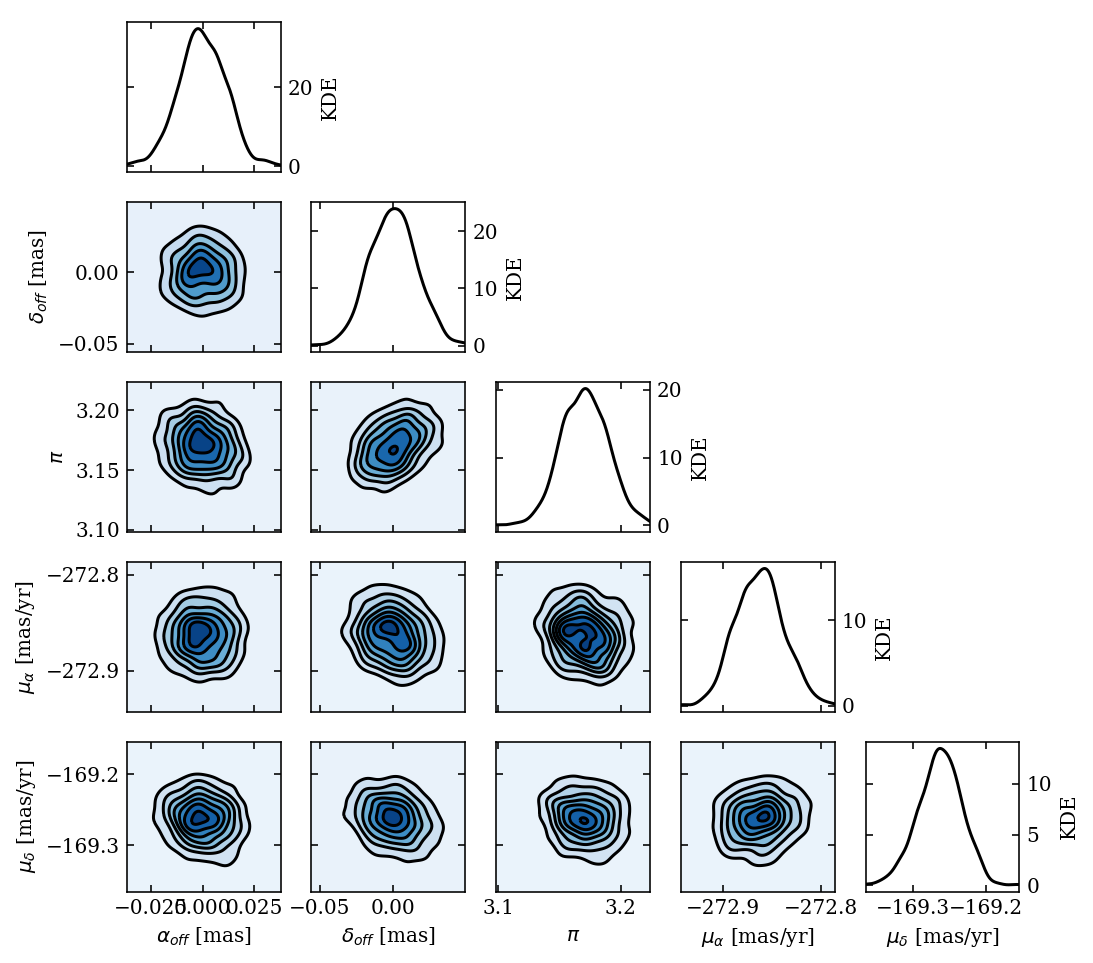

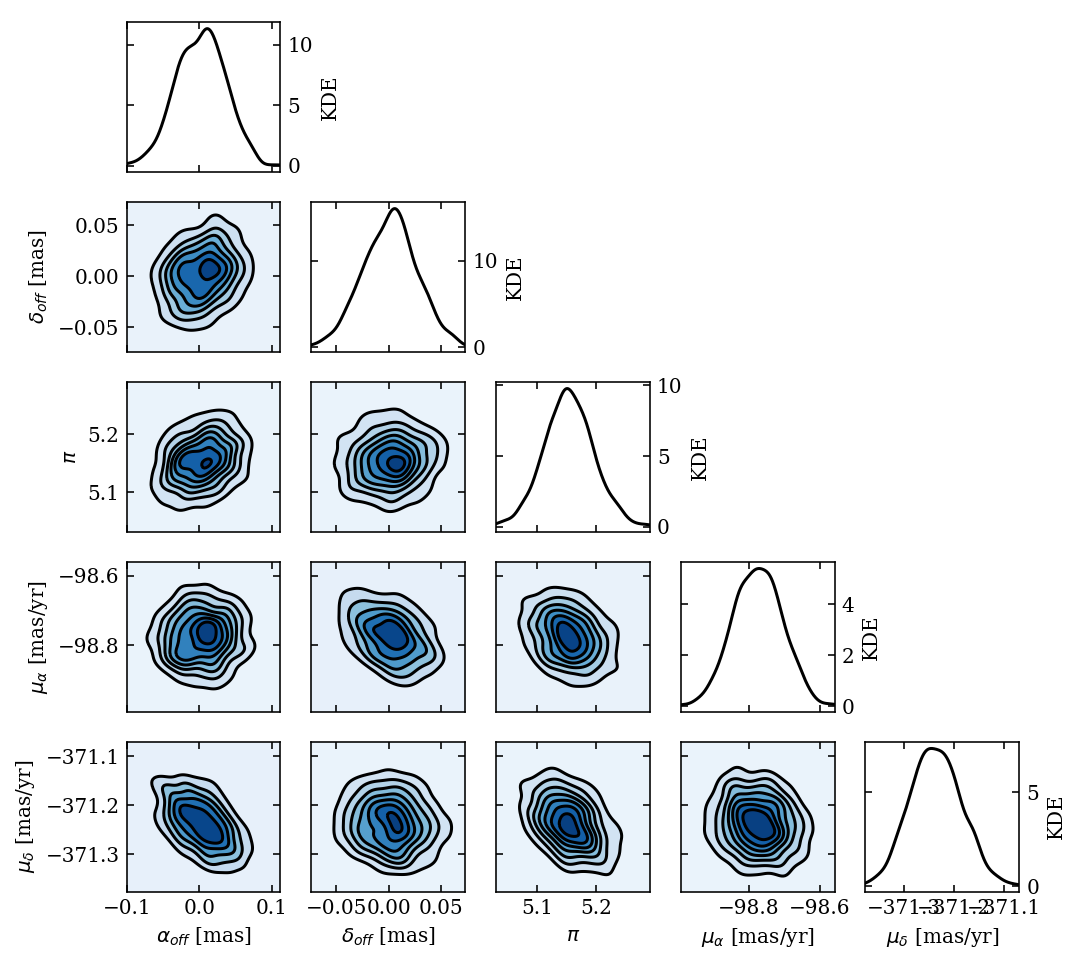

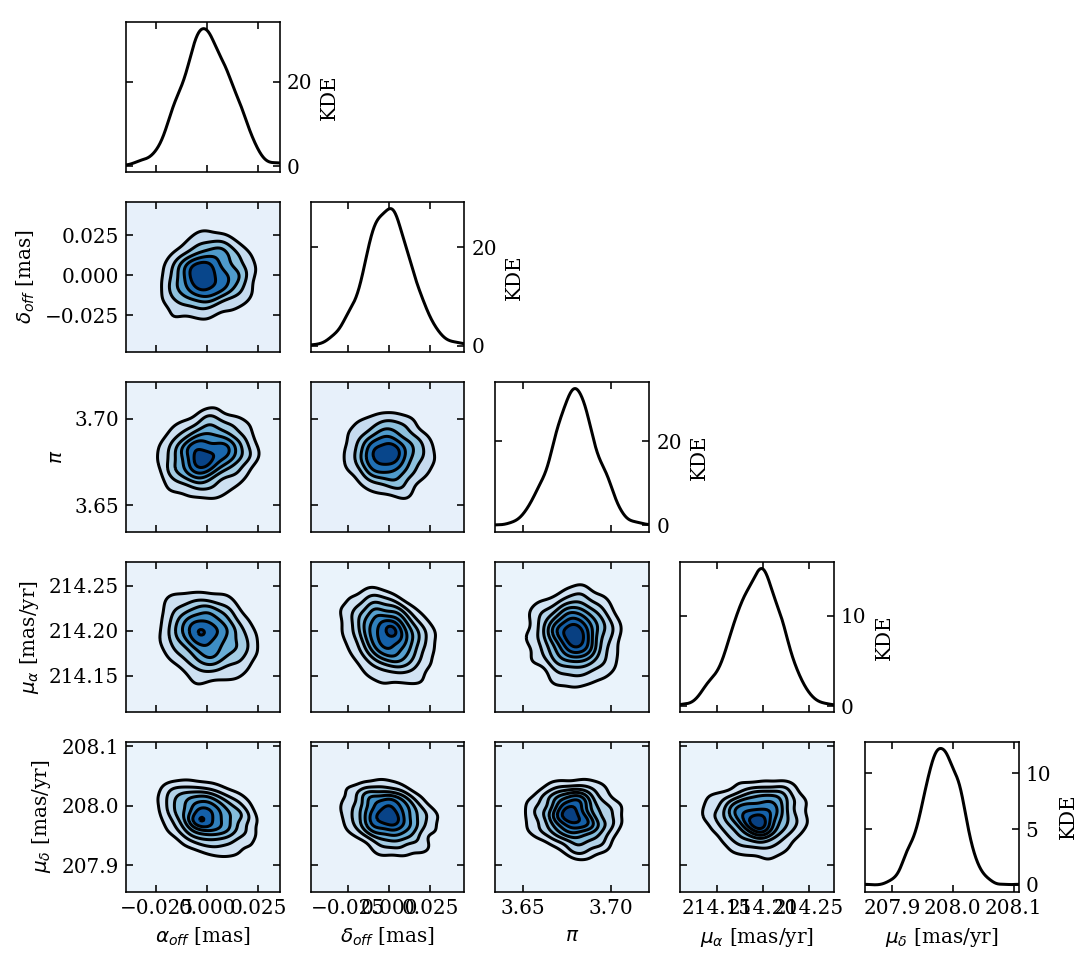

In [58]:
# Gaia abbreviations for PS coords, will be used to query table
ps_abbr = np.array(['ra','dec','parallax','pmra','pmdec'])

# Loop over all stars
for i in range(n_stars):
    
    # First gather the means:
    means = np.zeros(5)
    for j in range(5):
        if j == 0 or j == 1:
            means[j] = tab[i][ps_abbr[j]] * (1000*3600) # Deg -> mas
        else:
            means[j] = tab[i][ps_abbr[j]]
        ##fi
    ###j
    
    # Generate the covaraiance matrix
    cov = np.zeros((5,5))
    for j in range(5):
        for k in range(5):
            if j == k:
                cov[j,k] = tab[i][ps_abbr[j]+'_error']**2
            else:
                try:
                    corr = tab[i][ps_abbr[j]+'_'+ps_abbr[k]+'_corr']
                except KeyError:
                    corr = tab[i][ps_abbr[k]+'_'+ps_abbr[j]+'_corr']
                cov[j,k] = tab[i][ps_abbr[j]+'_error'] * tab[i][ps_abbr[k]+'_error'] * corr
            ##ie
        ###k
    ###j
    
    # Sample from the covariance matrix
    samples = np.random.multivariate_normal( means, cov, size=1000 )
    sample_labels = np.array([r'$\alpha_{off}$ [mas]',
                              r'$\delta_{off}$ [mas]',
                              r'$\pi$',
                              r'$\mu_{\alpha}$ [mas/yr]',
                              r'$\mu_{\delta}$ [mas/yr]'])
    
    # Make RA/Dec offsets and in mas
    samples[:,0] = (samples[:,0]-means[0])
    samples[:,1] = (samples[:,1]-means[1])
    
    # Create the stair plot
    fig, axs = ohstars.plot.staircase_plot(samples, sample_labels)
    fig.savefig('plots/'+star_names[i]+'_stair_plot.pdf')
    
###i
    
    
   
    

## Finish
Now this will be implemented as a function to easily sample the distribution of gaia parameters